In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sbi.utils as utils
from sbi.inference import infer

In [2]:
N_POP = 4
N_SIMU = 200

In [3]:
H0 = (torch.arange(N_POP) + 1) * 100

In [4]:
class MyAPrior(torch.distributions.Distribution):
    def __init__(
        self,
        n_pop: int,
        inner_low: torch.Tensor,
        inner_high: torch.Tensor,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.n_pop = n_pop

        self.inner_prior = torch.distributions.Uniform(
            low=inner_low,
            high=inner_high
        )

    def rsample(
        self,
        sample_shape=torch.Size([])
    ):
        a, b, c = torch.movedim(
            self.inner_prior.sample(sample_shape),
            -1,
            0
        )

        A = torch.zeros(sample_shape + (self.n_pop, self.n_pop))
        A += torch.diag_embed(
            torch.stack([b] * (self.n_pop -1), axis=-1),
            offset=1
        )
        A += torch.diag_embed(
            torch.stack([-b] * (self.n_pop -1), axis=-1),
            offset=-1
        )
        A += torch.diag_embed(
            torch.stack([-c] * (self.n_pop -1) + [a], axis=-1),
            offset=0
        )
    
        return A.view(sample_shape + (self.n_pop ** 2,))

    def log_prob(
        self,
        value
    ):
        sample_shape = value.shape[:-1]
        A = value.view(sample_shape + (self.n_pop, self.n_pop))
        a =  A[..., -1, -1]
        b =  A[...,  0,  1]
        c = -A[...,  0,  0]

        return torch.sum(
            self.inner_prior.log_prob(
                torch.stack(
                    [a, b, c],
                    axis=-1
                )
            ),
            axis=-1
        )

In [5]:
my_A_prior = MyAPrior(
    n_pop=N_POP,
    inner_low=torch.Tensor([9e-2, 4e-5, 3e-2]),
    inner_high=torch.Tensor([11e-2, 6e-5, 5e-2])
)

In [6]:
def f(x, r, A):
    return r + torch.sum(A * x.unsqueeze(-2), axis=-1)


def simulator(theta):
    sample_shape = theta.shape[:-1]
    r = torch.Tensor([-c, -c, -c,  a])
    A = theta.view(sample_shape + (N_POP, N_POP))
    
    H = torch.zeros(sample_shape + (N_POP, N_SIMU))
    H[..., 0] = H0.clone()
    dt = 0.5

    noise = torch.distributions.Normal(
        loc=torch.zeros(sample_shape + (N_POP,)),
        scale=5
    )
    
    for i in range(1, N_SIMU):
        H[..., i] = torch.maximum(
            torch.Tensor([0]),
            H[..., i-1] + dt * H[..., i-1] * f(H[..., i-1], r, A) # + noise.sample()
        )
    
    return H

In [7]:
a = 0.1
b = 5e-5
c = 0.04

theta = torch.Tensor(
    [
        [ 0,  b,  0,  0],
        [-b,  0,  b,  0],
        [ 0, -b,  0,  b],
        [ 0,  0, -b,  0]
    ]
).view((1, -1,))

In [8]:
observations = simulator(theta)

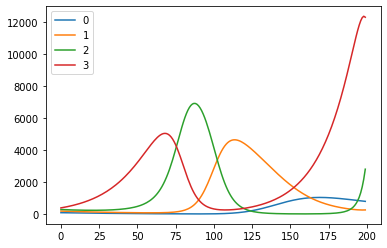

In [9]:
for i in range(N_POP):
    plt.plot(observations[0, i, :])

plt.legend([str(i) for i in range(N_POP)])
plt.show()

In [10]:
embedding = nn.Sequential(
    nn.Conv1d(N_POP, 16, kernel_size=5),
    nn.ReLU(),
    nn.Conv1d(16, 16, kernel_size=5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(3072, 20)
)

In [11]:
from sbi import utils
from sbi import inference
from sbi.inference import SNPE

# make a SBI-wrapper on the simulator object for compatibility
# simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=embedding)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=my_A_prior, density_estimator=neural_posterior)

# run the inference procedure on one round and 10000 simulated data points
theta_samples = my_A_prior.sample((5000,))
x = simulator(theta_samples)

In [12]:
density_estimator = inference.append_simulations(theta_samples, x).train()
posterior = inference.build_posterior(density_estimator)

Neural network successfully converged after 219 epochs.


In [14]:
# theta = my_A_prior.sample()

observation = simulator(theta)
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples,
                #    limits=[[0,0.5],[0,1e-4],[0,0.5], [0, 2e-4]],
                   points=theta,
                   points_offdiag={'markersize': 6},
                   points_colors='r',
                   fig_size=(12,12))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]WARNING:root:Only 0% posterior samples are within the
                        prior support. It may take a long time to collect the remaining
                        10000 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.
Drawing 10000 posterior samples:   0%|          | 0/10000 [00:24<?, ?it/s]

KeyboardInterrupt: 